###  <center> Management and Analysis of Physics Datasets - Mod. B

# <center> Analysis of Covid-19 papers #

**Matteo Bortoletto** - 1242935 | **Clelia Corridori** - 1234567 | **Michele Puppin** - 1227474
    

 
 *Padova, 12 July 2020*

# 1 - Introduction

Since this year our activities are determined by the COVID-19 pandemic, the distributed
computing project will be focused on the analysis of 1000 papers about COVID-19, SARS-
CoV-2, and related corona viruses. The dataset is a sub-sample of 1000 items taken from
the original dataset that is composed of more than 75000 papers. This dataset is a part
of real-world research on COVID-19 named COVID-19 Open Research Dataset Challenge
(CORD-19). The research and related challenges are available on the dedicated page on
Kaggle: https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

# 2 - Structure of the Data

All the documents presents in the *data* folder are structured in this way:

# 3 - Assignment

## 3.1 - Word counter distributed algorithm

First of all, you have to implement the following distributed algorithm to count the occurrences of all the words inside a list of documents. In NLP (Natural Language Processing) a documents is a text, in this case, each paper is a document. The algorithm is defined as follow:

1. **Map phase**: For each document $D_i$, produce the set of intermediate pairs $(w, cp(w))$, one for each word $w \in D_i$, where $cp(w)$ is the number of occurrences of $w$ in $D_i$.

2. **Reduce phase**: For each word $w$, gather all the previous pairs $(w, cp(w))$ and return the final pair $w,c(w))$ where $c(w)$ is the number of occurrences of $w$ for all the Documents. In other words, $c(w)$ is equal to $\sum_{k=1}^n cp_k(w)$.

The algorithm has be run on the full-text of the papers. To get the full text of the paper you have to transform the input data by concatenating the strings contained into the body-text fields of the JSONs.

To perform this transformation I strongly suggest you use the Bag data-structure of DASK. Anyway if you prefer to implement the algorithm by using the DataFrame structure feel free to do it.

The algorithm has be run several times by changing the number of workers and the number of partitions. For each run the execution time must be registered. Provide a comment on how change the computation time over the cluster by changing the partitions and the number of workers.

You have to try with at least 6 different partition numbers. At the end of the algorithm analyze the top words and see how they are related to the viruses and the research (for example create a barplot of the top words).

In [1]:
# Import useful packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import json
from collections import Counter
import time
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

# Import Dask packages
from dask.distributed import Client, LocalCluster
import dask.bag as db

# Import nltk packages
import nltk as nlt
#nlt.download('stopwords')
#nlt.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer

In [2]:
# Create Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:46491 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 33.59 GB


In [3]:
# Read files

papers = db.read_text('data/papers_in_json/*.json').map(json.loads).repartition(50)

In [4]:
# Join all paragraphs in the body text for each paper

def join_paragraphs(paper):
    
    full_text = ''
    
    for word in paper["body_text"]:
        full_text += ''.join(word["text"])
        
    return full_text

full_text = papers.map(join_paragraphs)

In [5]:
full_text.take(1) # First paper body text

('Plasmodium falciparum, which causes malignant malaria such as cerebral malaria (CM) or pregnancy-associated malaria (PAM) [1, 2] , is the cause of death to 435,000 individuals annually [3] . Plasmodium falciparum erythrocyte membrane protein 1 (PfEMP1), which is encoded by the var gene family comprising approximately 60 members, is the major virulence factor involved in the antigenic variation and clinical pathogenicity of falciparum malaria [4, 5] . It is remarkable that the expression of var family members is mutually exclusive. For each parasite at a time, only one or a few var genes are expressed, while the remaining members are silenced [6, 7] . In each generation, P. falciparum is able to express different var genes, and the switches in var gene expression lead to antigenic variation of PfEMP1, which results in immune evasion and chronic infection [8] [9] [10] [11] . This process has proven to be mediated by epigenetic mechanisms, including chromatin modification, nuclear archi

In [6]:
# Text filtering and sanification

tokenizer = RegexpTokenizer(r'\w+') # Splits the text into words

redundant_words = {"may", "i", "as", "also", "use", "used", "or", # Additional words to neglect
                   "et", "also", "one", "two", "it", "fig", "al"}

def filter_text(text, stop_words): # Lower all, remove non alphabetic words and stop_words
        
    filtered_text = ''
    
    for word in text:
        if word.lower() not in stop_words and word.isalpha(): 
            filtered_text = filtered_text + word + " "
            
    return tokenizer.tokenize(filtered_text)

def text_sanitizer(text): # Sanitize the text
    
    stop_words = set(stopwords.words('english')).union(redundant_words) # Remove stopwords and redundant words
    tokenized_text = word_tokenize(text) # Splits the text into words
    sanitized_text = filter_text(tokenized_text, stop_words) # Apply filter
    
    return sanitized_text

sanitized_text = full_text.map(text_sanitizer)

In [7]:
sanitized_text.take(1) # Sanitized first paper bodytext

(['Plasmodium',
  'falciparum',
  'causes',
  'malignant',
  'malaria',
  'cerebral',
  'malaria',
  'CM',
  'malaria',
  'PAM',
  'cause',
  'death',
  'individuals',
  'annually',
  'Plasmodium',
  'falciparum',
  'erythrocyte',
  'membrane',
  'protein',
  'encoded',
  'var',
  'gene',
  'family',
  'comprising',
  'approximately',
  'members',
  'major',
  'virulence',
  'factor',
  'involved',
  'antigenic',
  'variation',
  'clinical',
  'pathogenicity',
  'falciparum',
  'malaria',
  'remarkable',
  'expression',
  'var',
  'family',
  'members',
  'mutually',
  'exclusive',
  'parasite',
  'time',
  'var',
  'genes',
  'expressed',
  'remaining',
  'members',
  'silenced',
  'generation',
  'falciparum',
  'able',
  'express',
  'different',
  'var',
  'genes',
  'switches',
  'var',
  'gene',
  'expression',
  'lead',
  'antigenic',
  'variation',
  'results',
  'immune',
  'evasion',
  'chronic',
  'infection',
  'process',
  'proven',
  'mediated',
  'epigenetic',
  'mechani

### 1. Map Phase

In [8]:
# Find and count unique words

def word_counter(text):
    word_dict = {}
        
    for word in text:
        if word in word_dict:
            word_dict[word] += 1
        else:
            word_dict[word] = 1
            
    return word_dict

counted_text = sanitized_text.map(word_counter)

In [9]:
counted_text.take(1) # Unique and counted words in first paper bodytext

({'Plasmodium': 5,
  'falciparum': 27,
  'causes': 2,
  'malignant': 1,
  'malaria': 6,
  'cerebral': 1,
  'CM': 1,
  'PAM': 1,
  'cause': 1,
  'death': 1,
  'individuals': 1,
  'annually': 1,
  'erythrocyte': 1,
  'membrane': 1,
  'protein': 19,
  'encoded': 1,
  'var': 58,
  'gene': 36,
  'family': 6,
  'comprising': 2,
  'approximately': 2,
  'members': 4,
  'major': 5,
  'virulence': 3,
  'factor': 2,
  'involved': 9,
  'antigenic': 3,
  'variation': 7,
  'clinical': 1,
  'pathogenicity': 1,
  'remarkable': 1,
  'expression': 42,
  'mutually': 2,
  'exclusive': 2,
  'parasite': 32,
  'time': 4,
  'genes': 40,
  'expressed': 12,
  'remaining': 1,
  'silenced': 1,
  'generation': 1,
  'able': 1,
  'express': 1,
  'different': 12,
  'switches': 1,
  'lead': 3,
  'results': 13,
  'immune': 2,
  'evasion': 2,
  'chronic': 1,
  'infection': 1,
  'process': 12,
  'proven': 1,
  'mediated': 1,
  'epigenetic': 2,
  'mechanisms': 1,
  'including': 6,
  'chromatin': 17,
  'modification': 3,
 

### 2. Reduce Phase

In [10]:
# Merge all counted unique words 

def merge_dict(x, y):
    
    z = dict(Counter(x)+Counter(y))
    
    return z

words_dictionary = counted_text.fold(merge_dict).compute() 

In [11]:
words_dictionary # All counted unique words

{'Plasmodium': 52,
 'falciparum': 68,
 'causes': 726,
 'malignant': 170,
 'malaria': 199,
 'cerebral': 397,
 'CM': 11,
 'PAM': 13,
 'cause': 1355,
 'death': 1076,
 'individuals': 1340,
 'annually': 66,
 'erythrocyte': 33,
 'membrane': 1145,
 'protein': 5030,
 'encoded': 277,
 'var': 66,
 'gene': 2868,
 'family': 1042,
 'comprising': 111,
 'approximately': 703,
 'members': 654,
 'major': 1573,
 'virulence': 256,
 'factor': 1314,
 'involved': 1392,
 'antigenic': 288,
 'variation': 426,
 'clinical': 4287,
 'pathogenicity': 100,
 'remarkable': 109,
 'expression': 3525,
 'mutually': 39,
 'exclusive': 62,
 'parasite': 259,
 'time': 4481,
 'genes': 2162,
 'expressed': 1200,
 'remaining': 375,
 'silenced': 11,
 'generation': 412,
 'able': 1007,
 'express': 345,
 'different': 4561,
 'switches': 26,
 'lead': 850,
 'results': 4377,
 'immune': 2301,
 'evasion': 48,
 'chronic': 1072,
 'infection': 7300,
 'process': 1740,
 'proven': 212,
 'mediated': 344,
 'epigenetic': 48,
 'mechanisms': 887,
 'inc

### Top-words analysis

In [12]:
sort_orders = sorted(words_dictionary.items(), key=lambda x: x[1], reverse=True) # Sort words according to counts

sort_orders[0:15] # Top 15 words 

[('patients', 11586),
 ('cells', 10922),
 ('virus', 8326),
 ('study', 7365),
 ('infection', 7300),
 ('using', 6974),
 ('viral', 5890),
 ('data', 5862),
 ('disease', 5763),
 ('cell', 5241),
 ('protein', 5030),
 ('different', 4561),
 ('time', 4481),
 ('studies', 4420),
 ('results', 4377)]

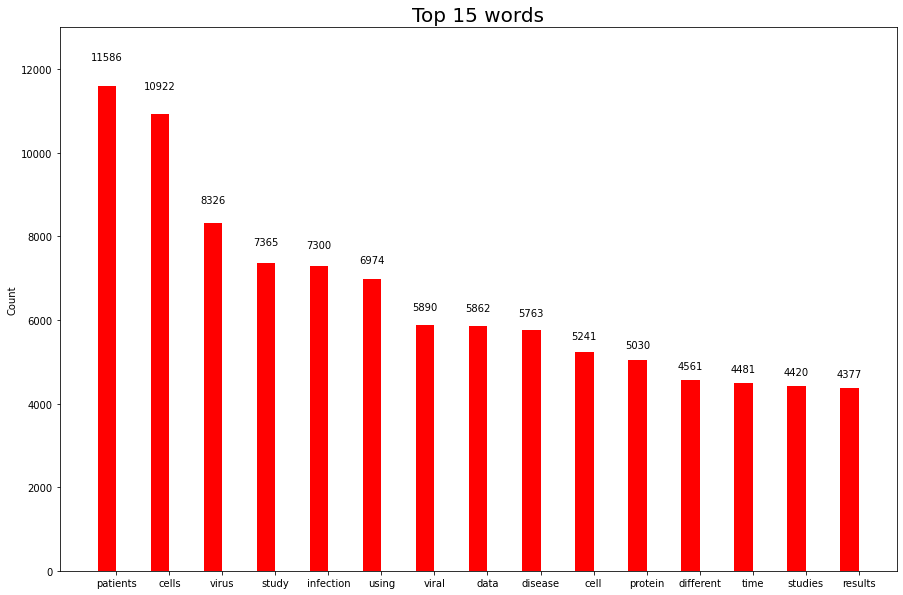

In [13]:
data = sort_orders[0:15]

names, values = zip(*data) 
ind = np.arange(len(data)) # x locations for the groups
width = 0.35 # width of the bars

fig, ax = plt.subplots(figsize = (15,10))
rects1 = ax.bar(ind, values, width, color = 'r')
ax.set_ylabel('Count')
ax.set_xticks(ind + width/2.)
ax.set_xticklabels(names)
ax.set_ylim([0,13000])
ax.set_title("Top 15 words", fontdict = {'fontsize' : 20})

def autolabel(rects): # Attach some text labels
    
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height, '%d' % int(height), ha='center', va='bottom') 
        
autolabel(rects1) 

plt.show()

In [14]:
client.close() # Close client

### Timing analysis

In [15]:
def timing(n_workers, n_partitions):
  
    cluster = LocalCluster(n_workers = n_workers)
    client = Client(cluster) 
    
    start = time.time() 
        
    papers = db.read_text('data/papers_in_json/*.json').map(json.loads).repartition(n_partitions)
    full_text = papers.map(join_paragraphs)
    sanitized_text = full_text.map(text_sanitizer)
    counted_text = sanitized_text.map(word_counter)
    words_dictionary = counted_text.fold(merge_dict).compute() 
    
    end = time.time()
    
    client.close()
    cluster.close() 
    
    computed_time = end - start
    
    return computed_time

In [16]:
workers = [1, 2, 4, 8, 16]
partitions = [1, 5, 10, 25, 50, 100]

times = []

for i in workers:
    for j in partitions:
        t = timing(i, j*i)
        times.append(t)
        print("Workers =", i, "Partitions =", i*j, "Time = {:.4f}".format(t),"s")

Workers = 1 Partitions = 1 Time = 100.6027 s
Workers = 1 Partitions = 5 Time = 110.3635 s
Workers = 1 Partitions = 10 Time = 104.8766 s
Workers = 1 Partitions = 25 Time = 102.5273 s
Workers = 1 Partitions = 50 Time = 101.1087 s
Workers = 1 Partitions = 100 Time = 101.0087 s
Workers = 2 Partitions = 2 Time = 57.4773 s
Workers = 2 Partitions = 10 Time = 53.5732 s
Workers = 2 Partitions = 20 Time = 51.3771 s
Workers = 2 Partitions = 50 Time = 53.5563 s
Workers = 2 Partitions = 100 Time = 51.6947 s
Workers = 2 Partitions = 200 Time = 53.9161 s
Workers = 4 Partitions = 4 Time = 30.3385 s
Workers = 4 Partitions = 20 Time = 31.6514 s
Workers = 4 Partitions = 40 Time = 28.7952 s
Workers = 4 Partitions = 100 Time = 26.9473 s
Workers = 4 Partitions = 200 Time = 28.6772 s
Workers = 4 Partitions = 400 Time = 27.7352 s
Workers = 8 Partitions = 8 Time = 18.7232 s
Workers = 8 Partitions = 40 Time = 16.6805 s
Workers = 8 Partitions = 80 Time = 17.0960 s
Workers = 8 Partitions = 200 Time = 16.9085 s
Wo

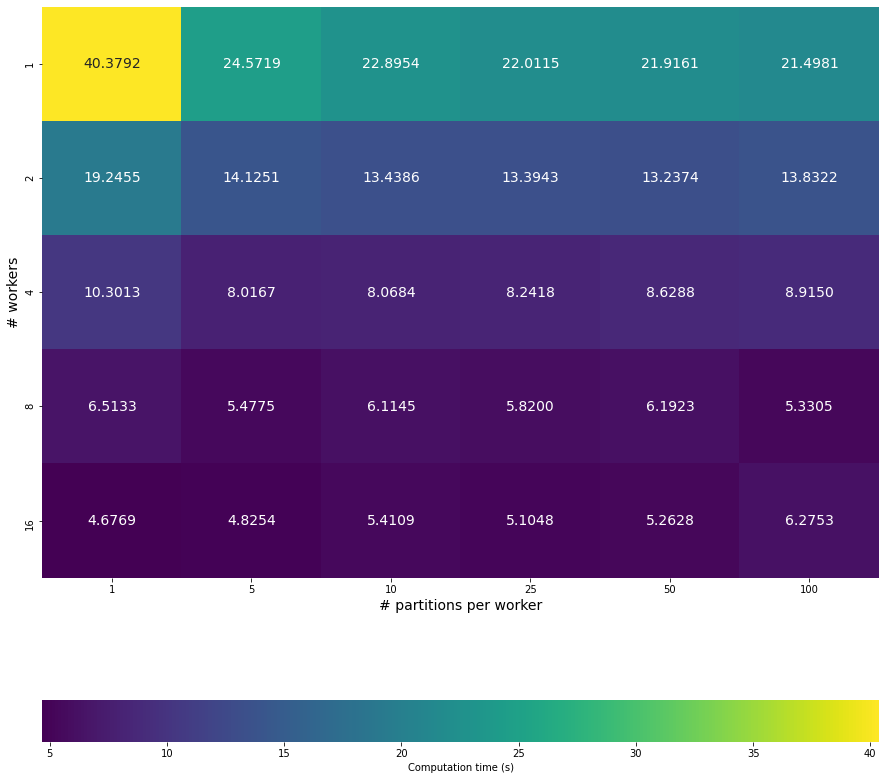

In [51]:
time_grid = np.array(times).reshape(len(workers), len(partitions))

df_time = pd.DataFrame(time_grid)

plt.figure(figsize=(15,15))

ax = sns.heatmap(df_time, annot=True, annot_kws={"size": 14}, fmt=".4f",
                xticklabels=partitions, yticklabels=workers,
                cbar_kws={'label':'Computation time (s)', 'orientation':'horizontal'}, cmap='viridis')
ax.set_xlabel("# partitions per worker", fontsize=14)
ax.set_ylabel("# workers", fontsize=14)

plt.show()

We observe that increasing the number of the workers we get better performances as far as timing is concerned.
Considering the number of partitions we note that there is a variability between different runs: the best result is obtained with 16 workers and a number of partition per worker below 50. However in general the best number of partitions is around 25/50 partitions per worker. 

## 3.2 - Which are the worst and best represented countries in the research?

In this part you have to take the documents and to convert them in a usable DataFrame data structure in order to figure out the countries that are most and less active in the research. To do this you can use the country of the authors. Do the same for the universities (affiliations). Even in this case do multiple runs by changing the number of partitions and workers and then describe the behaviour of the timings.

In [18]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:36831 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 33.59 GB


In [19]:
papers = db.read_text('data/papers_in_json/*.json').map(json.loads).repartition(50)

papers_location = papers.pluck('metadata').pluck('authors') # Extract authors from metadata

In [20]:
# Extract location for each author in each paper

def location_filter(paper):
    university = ''
    location = ''
    laboratory = ''
    
    if 'laboratory' in paper['affiliation'].keys():
        laboratory = paper['affiliation']['laboratory']
    else: laboratory = 'NA'
    if laboratory == '': 
        laboratory = 'NA'
        
    if 'institution' in paper['affiliation'].keys():
        university = paper['affiliation']['institution']
    else: university = 'NA'
    if university == '': 
        university = 'NA'
    
    if 'location' in paper['affiliation'].keys():
        if 'country' in paper['affiliation']['location'].keys():
            location = paper['affiliation']['location']['country']
        elif 'region' in paper['affiliation']['location'].keys():
            location = paper['affiliation']['location']['region']
    else: location = 'NA'
    if location == '':
        location = 'NA'
    
    return {'University': university, 'Laboratory': laboratory, 'Country/Region': location}

In [21]:
papers_location.flatten().map(location_filter).take(1) # Location info for the first author of the first paper

({'University': 'Second Military Medical University',
  'Laboratory': 'NA',
  'Country/Region': 'China'},)

In [22]:
# Create dataframe and sort according to most represented country/university

location_df = papers_location.flatten().map(location_filter).to_dataframe()
countries = location_df['Country/Region'].value_counts()
universities = location_df['University'].value_counts()

countries_dict = countries.compute().to_dict()
countries_dict = sorted(countries_dict.items(), key=lambda x: x[1], reverse=True)

universities_dict = universities.compute().to_dict()
universities_dict = sorted(universities_dict.items(), key=lambda x: x[1], reverse=True)

### Countries

In [23]:
countries_dict[1:16] # Top 15 countries

[('China', 617),
 ('USA', 370),
 ('Italy', 222),
 ('France', 113),
 ('UK', 110),
 ('Spain', 109),
 ('Canada', 103),
 ('Japan', 94),
 ('Brazil', 72),
 ('Taiwan', 68),
 ('Germany', 66),
 ('United States', 51),
 ('Australia', 46),
 ('The Netherlands', 42),
 ('Korea', 40)]

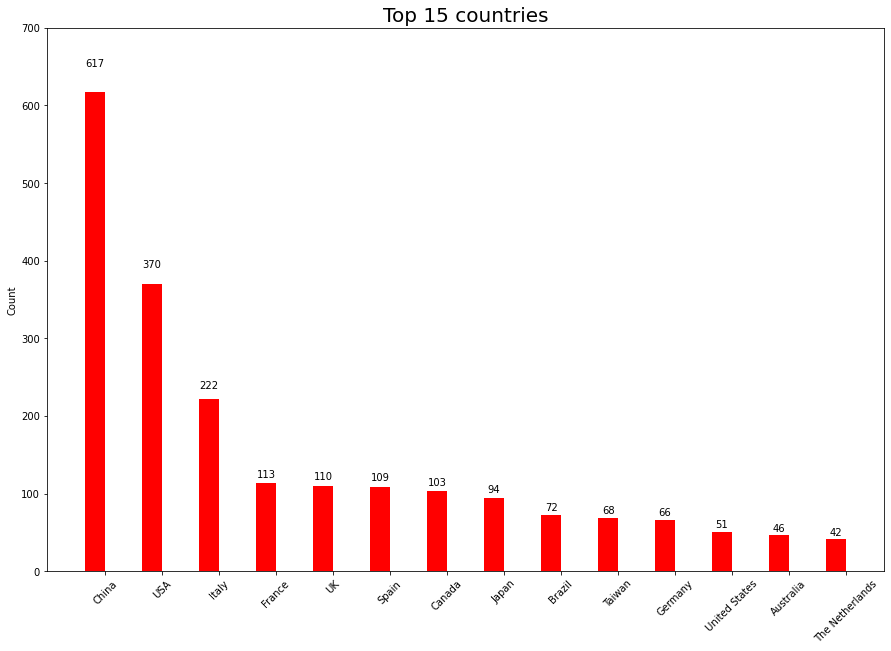

In [24]:
data = countries_dict[1:15]

names, values = zip(*data) 
ind = np.arange(len(data)) 
width = 0.35 
fig, ax = plt.subplots(figsize=(15,10))
rects1 = ax.bar(ind, values, width, color='r')
ax.set_ylabel('Count')
ax.set_xticks(ind+width/2.)
plt.xticks(rotation=45)
ax.set_xticklabels(names)
ax.set_ylim([0,700])
ax.set_title("Top 15 countries", fontdict = {'fontsize' : 20})

def autolabel(rects):

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height, '%d' % int(height), ha='center', va='bottom') 
        
autolabel(rects1) 

In [25]:
countries_dict[-15:-1] # Worst represented countries

[('Mississippi', 1),
 ('ORCID', 1),
 ('the Netherlands., the Netherlands', 1),
 ('France 15', 1),
 ('Myanmar', 1),
 ('Florida', 1),
 ('NC', 1),
 ('NH', 1),
 ('NY (', 1),
 ('NY, NY', 1),
 ('Nebraska', 1),
 ('New Jersey', 1),
 ('OH', 1),
 ('Japan (', 1)]

### Universities

In [26]:
universities_dict[1:16] # Top 15 universities

[('The University of Hong Kong', 57),
 ('Verona University Hospital Trust', 55),
 ('Chinese Academy of Sciences', 42),
 ('University of California', 29),
 ('Third Military Medical University', 27),
 ('Fudan University', 26),
 ('Huazhong Agricultural University', 26),
 ('Utrecht University', 25),
 ('Harvard Medical School', 23),
 ('Huazhong University of Science and Technology', 23),
 ('National Institutes of Health', 23),
 ('Zhejiang University', 23),
 ('Qingdao University', 22),
 ('National Institute of Infectious Diseases', 20),
 ('University of Minnesota', 19)]

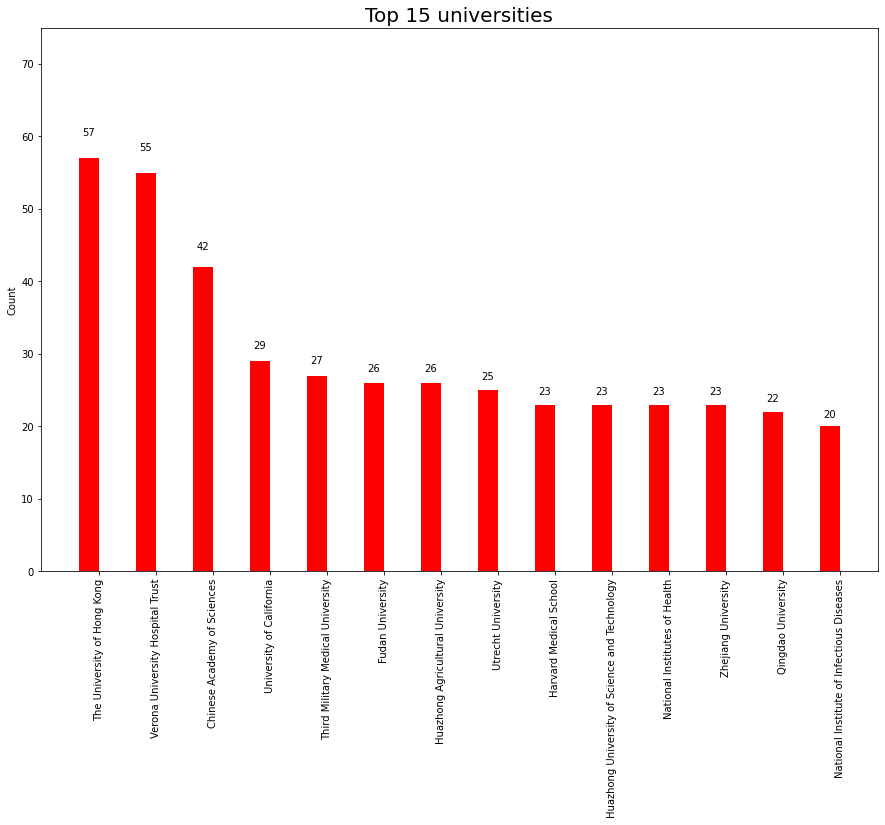

In [27]:
data = universities_dict[1:15]

names, values = zip(*data) 
ind = np.arange(len(data)) 
width = 0.35 
fig, ax = plt.subplots(figsize=(15,10))
rects1 = ax.bar(ind, values, width, color='r')
ax.set_ylabel('Count')
ax.set_xticks(ind+width/2.)
plt.xticks(rotation=90)
ax.set_xticklabels(names)
ax.set_ylim([0,75])
ax.set_title("Top 15 universities", fontdict = {'fontsize' : 20})

def autolabel(rects):

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height, '%d' % int(height), ha='center', va='bottom') 
        
autolabel(rects1) 

In [28]:
universities_dict[-15:-1] # Worst represented universities

[('Korea Food Research Institute', 1),
 ('Thoracic Institute and Lerner Research Institute', 1),
 ('Thomas Jefferson Medical Collage', 1),
 ('ThivervaI-Grignon (France)', 1),
 ('Thermo Fisher Scientific', 1),
 ('The University of Sheffield', 1),
 ('Kursk State University', 1),
 ('Kwangwoon University', 1),
 ('La Trobe University', 1),
 ('The University of Manchester', 1),
 ('Late-stage Development', 1),
 ('Laval University', 1),
 ('The University of Georgia', 1),
 ('Liceo Statale Augusto Righi', 1)]

In [29]:
client.close() # Close client

### Countries timing analysis

In [30]:
def timing(n_workers, n_partitions):
  
    cluster = LocalCluster(n_workers = n_workers)
    client = Client(cluster) 
    
    start = time.time() 
        
    papers = db.read_text('data/papers_in_json/*.json').map(json.loads).repartition(n_partitions)
    papers_location = papers.pluck('metadata').pluck('authors')
    location_df = papers_location.flatten().map(location_filter).to_dataframe()
    countries = location_df['Country/Region'].value_counts()

    countries_dict = countries.compute().to_dict()
        
    end = time.time()
    
    client.close()
    cluster.close() 
    
    computed_time = end - start
    
    return computed_time

In [31]:
workers = [1, 2, 4, 8, 16]
partitions = [1, 5, 10, 25, 50, 100]

times = []

for i in workers:
    for j in partitions:
        t = timing(i, j*i)
        times.append(t)
        print("Workers =", i, "Partitions =", i*j, "Time = {:.4f}".format(t),"s")

Workers = 1 Partitions = 1 Time = 40.3792 s
Workers = 1 Partitions = 5 Time = 24.5719 s
Workers = 1 Partitions = 10 Time = 22.8954 s
Workers = 1 Partitions = 25 Time = 22.0115 s
Workers = 1 Partitions = 50 Time = 21.9161 s
Workers = 1 Partitions = 100 Time = 21.4981 s
Workers = 2 Partitions = 2 Time = 19.2455 s
Workers = 2 Partitions = 10 Time = 14.1251 s
Workers = 2 Partitions = 20 Time = 13.4386 s
Workers = 2 Partitions = 50 Time = 13.3943 s
Workers = 2 Partitions = 100 Time = 13.2374 s
Workers = 2 Partitions = 200 Time = 13.8322 s
Workers = 4 Partitions = 4 Time = 10.3013 s
Workers = 4 Partitions = 20 Time = 8.0167 s
Workers = 4 Partitions = 40 Time = 8.0684 s
Workers = 4 Partitions = 100 Time = 8.2418 s
Workers = 4 Partitions = 200 Time = 8.6288 s
Workers = 4 Partitions = 400 Time = 8.9150 s
Workers = 8 Partitions = 8 Time = 6.5133 s
Workers = 8 Partitions = 40 Time = 5.4775 s
Workers = 8 Partitions = 80 Time = 6.1145 s
Workers = 8 Partitions = 200 Time = 5.8200 s
Workers = 8 Parti

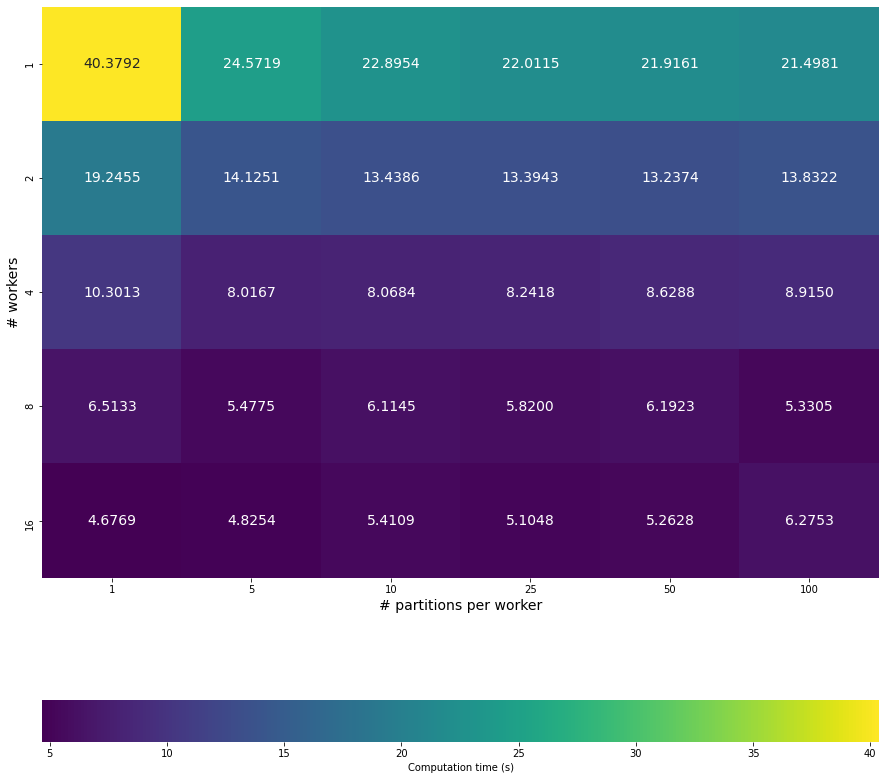

In [50]:
time_grid = np.array(times).reshape(len(workers), len(partitions))

df_time = pd.DataFrame(time_grid)

plt.figure(figsize=(15,15))

ax = sns.heatmap(df_time, annot=True, annot_kws={"size": 14}, fmt=".4f",
                xticklabels=partitions, yticklabels=workers,
                cbar_kws={'label':'Computation time (s)', 'orientation':'horizontal'}, cmap='viridis')
ax.set_xlabel("# partitions per worker", fontsize=14)
ax.set_ylabel("# workers", fontsize=14)

plt.show()

Also in this case we can make analogous considerations as for the previous timing analysis. In particular the best result is obtained with 16 workers and 50 partitions per worker.

## 3.3 - Get the embedding for the title of the papers

In NLP a common technique to perform analysis over a set of texts is to transform the text to a set of vectors each one representing a word inside a document. At the end of the pre-processing the document will be transformed into a list of vectors or a matrix of $n \times m$ where n is the number of words in the document and m is the size of the vector that represents the word $n$.

What you can do is to transform the title of the paper into its embedding version by using the pre-trained model available on FastText page: https://fasttext.cc/docs/en/pretrainedvectors.html.

The pre-trained model that you have to download is the https://dl.fbaipublicfiles.com/fasttext/vecwiki/wiki.en.vec.
Basically the pre-trained model is more or less a huge dictionary in the following format `key: vector`.


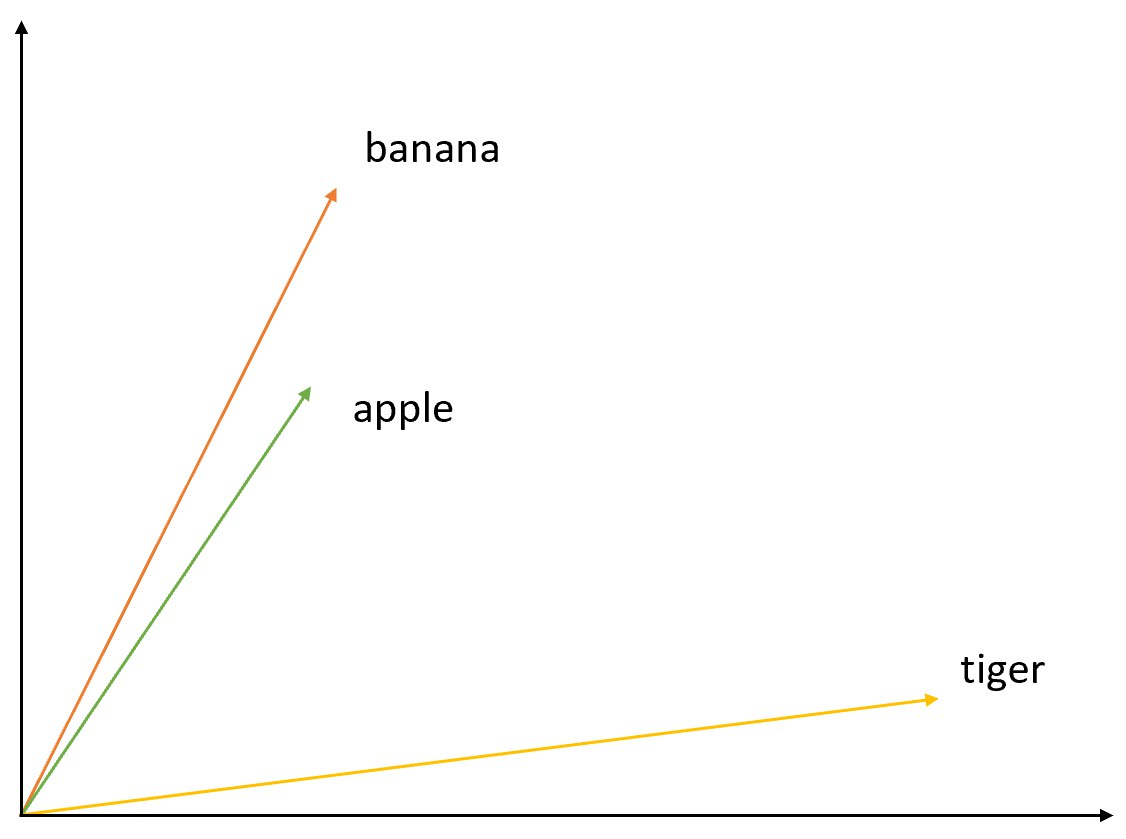

In [33]:
from IPython.display import Image
Image(filename='cosine.jpg',width = 600, height = 300) 

In [34]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:37577 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 33.59 GB


In [35]:
papers = db.read_text('data/papers_in_json/*.json').map(json.loads).repartition(80) # Read data

papers_title = papers.pluck('metadata').pluck('title') # Extract title from metadata

sanitized_title = papers_title.map(text_sanitizer) # Sanitize title

In [36]:
# Find unique words in title

def find_unique(text):
    word_dict = []
        
    for word in text:
        if word not in word_dict:
            word_dict.append(word)
        else:
            continue
            
    return word_dict

unique_title = sanitized_title.map(find_unique) 

In [37]:
# Merge all titles as unique list of strings 

def merge_list(x, y):
    return list(set(x) | set(y)) 

reduce = unique_title.fold(merge_list)

words_list = reduce.compute() # List of all unique words in all papers

In [38]:
# Load embedding pre-trained model selecting only the words in words_list

def load_vectors(fname):
    
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    
    for line in fin:
        tokens = line.rstrip().split(' ')
        if tokens[0] in words_list: # Only words in word_list
            data[tokens[0]] = np.array(tokens[1:], dtype=np.float32)
            
    return data

model = load_vectors('wiki.en.vec')

In [39]:
def title_embedding(title): # Get title embedding
    
    embedding = []
        
    for word in title:
        try:
            embedding.append(model[word])
        except:
            pass
        
    return(np.array(embedding))

def title_id(paper): # Get paper ID with its associated embedded title
    
    paper_id = paper['paper_id']
    
    papers_title = paper['metadata']['title']
    sanitized_title = text_sanitizer(papers_title)
    embedded_title = title_embedding(sanitized_title)
    
    return {'paper_id': paper_id, 'embedded_title': embedded_title}

embedded_titles = papers.map(title_id)

In [40]:
embedded_titles.take(1) # Paper ID with its associated embedded title for the first paper

({'paper_id': '000a0fc8bbef80410199e690191dc3076a290117',
  'embedded_title': array([[-0.060458 ,  0.078149 , -0.2902   , ...,  0.098059 ,  0.24549  ,
          -0.15095  ],
         [ 0.26367  , -0.10324  , -0.37761  , ...,  0.72917  ,  0.36086  ,
          -0.46952  ],
         [ 0.26654  ,  0.28585  , -0.23893  , ...,  0.42146  ,  0.2114   ,
          -0.051213 ],
         ...,
         [-0.16178  , -0.11789  , -0.38479  , ...,  0.56534  , -0.16544  ,
           0.02002  ],
         [-0.021397 , -0.32793  , -0.11575  , ...,  0.31625  ,  0.23601  ,
          -0.42227  ],
         [-0.032332 ,  0.27025  , -0.27877  , ...,  0.69795  ,  0.0058579,
          -0.78555  ]], dtype=float32)},)

In [41]:
client.close() # Close client

### 3.3.1 - Bonus point

Use the previously generated vectors to compute the cosine similarity between each paper and to figure out a couple of papers with the highest cosine similarity score.

In [42]:
cluster = LocalCluster(n_workers = 16)
client = Client(cluster) 
client

Client Scheduler: tcp://127.0.0.1:37995 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 33.59 GB


In [43]:
papers = db.read_text('data/papers_in_json_500/*.json').map(json.loads).repartition(80) # Selection of subset

papers_title = papers.pluck('metadata').pluck('title') 

sanitized_title = papers_title.map(text_sanitizer) 

unique_title = sanitized_title.map(find_unique) 

reduce = unique_title.fold(merge_list)

words_list = reduce.compute()

embedded_titles = papers.map(title_id)

In [44]:
def cos_sim(u, v): # Define cosine similarity
    num = np.dot(u, v)
    den = np.linalg.norm(u) * np.linalg.norm(v)
    return num/den

In [45]:
def similarity(embedded_title): # Compute cosine similarity between a paper u and all other papers v
    
    u_embedded = embedded_title['embedded_title'].flatten()
    u_id = embedded_title['paper_id']
    
    sim = []
    
    for title in embedded_titles:
        
        v_embedded = title['embedded_title'].flatten()
        v_id = title['paper_id']
        
        min_length = min(len(u_embedded), len(v_embedded)) 
        s = cos_sim(u_embedded[:min_length], v_embedded[:min_length])
        
        if np.isnan(s):
            s = 0
            
        sim.append([u_id, v_id, s])
    
    return sim

In [46]:
similarities_info = embedded_titles.map(similarity).compute()

In [47]:
# Create a dataframe with results

all_id_1 = []
all_id_2 = []
all_sim = []

for i in range(len(similarities_info)):
    for j in range(len(similarities_info[i])):
        all_id_1.append(similarities_info[i][j][0])
        all_id_2.append(similarities_info[i][j][1])
        all_sim.append(similarities_info[i][j][2])
        
d = {'ID1': all_id_1,'ID2': all_id_2, 'SIM': all_sim}

df = pd.DataFrame(d)

In [48]:
# Neglect similarity between a paper and itself and sort in descending order

df_dep = df[df['ID1'] != df['ID2']]
df_dep = df_dep.sort_values(by = ['SIM'], ascending=False)

df_dep.head(15)

,ID1,ID2,SIM
194796,0b26d9ec6dfae866ae3f1a3f773036b1c8627147,0adc67dd5357d6059c21d54281273e4ffa20f6c4,1.0
194939,0b26d9ec6dfae866ae3f1a3f773036b1c8627147,0b5f8aa815f121c29d72e06b6fa8f1e1f7baa64c,1.0
194706,0b26d9ec6dfae866ae3f1a3f773036b1c8627147,0a951bc5290bff5f326fd2b5f90a7560ec79fb6d,1.0
85389,0a781fedeb91a2e59cde6fca0e5e7a6f3c643404,0b26d9ec6dfae866ae3f1a3f773036b1c8627147,1.0
148389,0adc67dd5357d6059c21d54281273e4ffa20f6c4,0b26d9ec6dfae866ae3f1a3f773036b1c8627147,1.0
70389,0a6091c17b036524ee4c11c1082b6d9af211e574,0b26d9ec6dfae866ae3f1a3f773036b1c8627147,1.0
194670,0b26d9ec6dfae866ae3f1a3f773036b1c8627147,0a781fedeb91a2e59cde6fca0e5e7a6f3c643404,1.0
194640,0b26d9ec6dfae866ae3f1a3f773036b1c8627147,0a6091c17b036524ee4c11c1082b6d9af211e574,1.0
161889,0aef63f4f4c4cb195e71b50d0c6e721aba9f2a81,0b26d9ec6dfae866ae3f1a3f773036b1c8627147,1.0
194627,0b26d9ec6dfae866ae3f1a3f773036b1c8627147,0a52a3d2793f8ca8a4d6f6630e986ea1da115f80,1.0


In [49]:
client.close() # Close Client
cluster.close() # Close Cluster